#### Coordinate-wise optimality

##### Differentiable function

Given a convex, differentiable $f$, if we are at a point $x$ such that $f(x)$ is minimized along each coordinate axis

$$f(x+\delta e_i)\geq f(x)\, \forall \delta , i$$

then $x$ is the global minimizer

This is because

$$\nabla f(x)=\left(\frac{\partial f}{\partial x_1}(x), \cdots, \frac{\partial f}{\partial x_n}(x)\right)=0$$

as each element in $\nabla f(x)$ is minimized at $x$

##### Separable function

Next, we consider the function

$$f(x)=g(x)+\sum_{i=1}^nh_i(x_i)$$

where $g$ is convex and differentiable and each $h_i$ is only convex

Since $x$ is such $f(x)$ is minimized along each coordinate axis, then for a point $y$, with subdifferential, we have

$$\begin{align*}
0 &\in \nabla_i g(x)+\partial h_i(x_i) \\
&\Longleftrightarrow -\nabla_ig(x)\in \partial h_i(x_i)\\
&\Longleftrightarrow h_i(y_i)\geq h_i(x_i)-\nabla_ig(x)(y_i-x_i)\\
&\Longleftrightarrow \nabla_ig(x)(y_i-x_i)+h_i(y_i)-h_i(x_i)\geq 0\\
\end{align*}$$

Then, we can write

$$\begin{align*}
f(y)-f(x)&=g(y)-g(x)+\sum_{i=1}^n \left(h_i(y_i)-h_i(x_i)\right) \\
&\geq \nabla g(x)^T(y-x)+\sum_{i=1}^n \left(h_i(y_i)-h_i(x_i)\right)\\
&=\sum_{i=1}^n \left[\nabla_ig(x)(y_i-x_i)+h_i(y_i)-h_i(x_i)\right]\\
&\geq 0
\end{align*}$$

Therefore, for separable $f$ here, if it is minimized along each coordinate axis, we also find the global optimizer

##### General non-differentiable function

However, the conclusion is NOT true if $f(x)$ is convex, but not differentiable in general

#### Coordinate descent

For problem

$$\min_x f(x)$$

where

$$f(x)=g(x)+\sum_{i=1}^nh_i(x_i)$$

with $g$ is convex and differentiable and each $h_i$ is only convex

and for some $x^0\in \mathbf{R}^n$, `coordinate descent` repeats

$$x_i^{k+1}=\arg\min_{x_i}f\left(x_1^{k+1}, \cdots, x_{i-1}^{k+1}, x_i, x_{i+1}^k,\cdots, x_n^k\right)$$

Here, we assume $x_1^{k+1}, \cdots, x_{i-1}^{k+1}$ have been updated and their updated version is used

Although in practice, the order of update does not really matter

#### LASSO example

For LASSO

$$\min_x \frac{1}{2}\|y-Ax\|_2^2+\lambda \|x\|_1$$

For the objective without $l_1$ constraint, we know how to minimize over $x_i$

$$0=A_i^T(Ax-y)=A_i^T(A_ix_i+A_{-i}x_{-i}-y)$$

and we denote it $c$

$$c=x_i=\frac{A_i^Tr_i}{A_i^TA_i}, r_i=y-A_{-i}x_{-i}$$

where $A_{-i}$ is $A$ without ith column and $A_i$ is the ith column

Now, for the full LASSO objective

$$\begin{align*}
x_i&=\min_{x_i} \frac{1}{2}\|r_i-A_ix_i\|_2^2+\lambda \|x_i\|_1 \\
&=\min_{x_i} \frac{1}{2}\left(A_i^TA_ix_i^2-2x_iA_i^Tr_i\right)+\lambda\|x_i\|_1\\
&=\min_{x_i} \frac{1}{2}A_i^TA_i\left(x_i^2-2cx_i\right)+\lambda\|x_i\|_1\\
&  \frac{1}{2}A_i^TA_ic^2 \text{ does not depend on }x_i \\
&=\min_{x_i} \frac{1}{2}A_i^TA_i\left(x_i-c\right)^2+\lambda\|x_i\|_1\\
&=\min_{x_i} \frac{1}{2}\left(x_i-c\right)^2+\lambda/(A_i^TA_i)\|x_i\|_1\\
& \text{this is exactly soft thresholding formulation}\\
&= S_{\lambda/\|A_i\|_2^2}(c)
\end{align*}$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

plt.style.use('dark_background')
# color: https://matplotlib.org/stable/gallery/color/named_colors.htm

In [ ]:
def cholesky_factorization(A):
    m = A.shape[0]
    l_mat = A.copy().astype(float)

    for k in range(m):
        if l_mat[k, k] <= 0:
            raise ValueError('Matrix is not positive definite')

        # Follow the first step, iteratively apply to a smaller and smaller K
        l_mat[k+1:, k+1:] -= np.outer(l_mat[k+1:, k], l_mat[k+1:, k]) / l_mat[k, k]
        l_mat[k:, k] /= np.sqrt(l_mat[k, k])

    return np.tril(l_mat)

def forward_substitution(L, b):
    m, n = L.shape
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(L[i, :i], x[:i])) / L[i, i]
    return x

def back_substitution(R, b):
    m, n = R.shape
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - np.dot(R[i, i + 1:], x[i + 1:])) / R[i, i]
    return x

In [ ]:
def subgrad_l1_ls(A, b, x1, lamb=0.5, a=1e-2, tol=1e-3, n_iter=3000):
    # l1-regularized least squares

    h = [np.inf]
    h_best = [np.inf]
    x = x1.copy()

    for k in range(1, n_iter+1):
        subgrad = A.T @ (A @ x - b) + lamb * np.sign(x)
        h_val = 0.5 * np.linalg.norm(A @ x - b)**2 + lamb * np.linalg.norm(x, ord=1)

        # Step size
        alpha = a / np.sqrt(k)

        h.append(h_val)
        h_best.append(min(h_val, h_best[-1]))

        # Subgradient step
        x = x - alpha * subgrad

    hist = {'h': h, 'h_best': h_best}

    return x, hist

In [ ]:
def prox_l1(x, lamb, t):
    # proximal operator on l1 norm
    return np.sign(x) * np.maximum(np.abs(x) - t * lamb, 0)

def h(x, A, b, lamb):
    return 0.5 * np.linalg.norm(A @ x - b)**2 + lamb * np.linalg.norm(x, ord=1)

def f(x, A, b):
    return 0.5 * np.linalg.norm(A @ x - b)**2

def ista_l1_ls(A, b, x1, lamb=0.5, tol=1e-8, n_iter=3000, min=min):
    h_hist = [np.inf]
    x = x1.copy()
    beta = 0.5
    t = 1

    for k in range(1, n_iter+1):
        z = prox_l1(x - t * A.T @ (A @ x - b), lamb, t)
        # backtracking line search
        while f(z, A, b) > f(x, A, b) + A.T @ (A @ x - b) @ (z - x) + 0.5 * np.linalg.norm(z - x)**2 / t:
            t *= beta
            z = prox_l1(x - t * A.T @ (A @ x - b), lamb, t)
        x = z
        h_hist.append(h(x, A, b, lamb))
        if abs(h_hist[-1] - min) < tol:
            break

    hist = {'h': h_hist}

    return x, hist

def fista_l1_ls(A, b, x1, lamb=0.5, tol=1e-8, n_iter=3000,min=min):
    h_hist = [np.inf]
    x = x1.copy()
    beta = 0.5
    t = 1
    x_prev = x1.copy()
    for k in range(1, n_iter+1):
        v = x + (k-1) / (k+2) * (x - x_prev)
        z = prox_l1(v - t * A.T @ (A @ v - b), lamb, t)
        # backtracking line search
        while f(z, A, b) > f(v, A, b) + A.T @ (A @ v - b) @ (z - v) + 0.5 * np.linalg.norm(z - v)**2 / t:
            t *= beta
            z = prox_l1(v - t * A.T @ (A @ v - b), lamb, t)
        x_prev = x
        x = z
        h_hist.append(h(x, A, b, lamb))
        if abs(h_hist[-1] - min) < tol:
            break

    hist = {'h': h_hist}

    return x, hist

def admm_l1_ls(A, b, x1, lamb=0.5, tol=1e-8, n_iter=3000, min=min):
    rho = 1/lamb
    h_hist = [np.inf]
    x = x1.copy()
    z = x1.copy()
    w = np.zeros_like(x)
    try:
        # L = np.linalg.cholesky(A.T @ A + rho * np.eye(A.shape[1]))
        L = cholesky_factorization(A.T @ A + rho * np.eye(A.shape[1]))
    except ValueError:
        raise ValueError('Matrix is not positive definite')

    for k in range(1, n_iter+1):
        y = forward_substitution(L, A.T @ b + rho * (z - w))
        x = back_substitution(L.T, y)
        z = prox_l1(x + w, lamb, 1/rho)
        w = w + x - z
        h_hist.append(h(x, A, b, lamb))
        if abs(h_hist[-1] - min) < tol:
            break

    hist = {'h': h_hist}

    return x, hist

def cd_l1_ls(A, b, x1, lamb=0.5, tol=1e-8, n_iter=3000, min=min):
    h_hist = [np.inf]
    x = x1.copy()
    m, n = A.shape

    r = b - A @ x
    for k in range(1, n_iter+1):
        for i in range(n):
            x_old = x[i]
            A_i_sq = (A[:, i] @ A[:, i])
            c = A[:, i] @ r / A_i_sq + x_old
            x[i] = prox_l1(c, lamb / A_i_sq, 1)
            r -= A[:, i] * (x[i] - x_old)

        h_hist.append(h(x, A, b, lamb))

        if abs(h_hist[-1] - min) < tol:
            break

    hist = {'h': h_hist}

    return x, hist

In [ ]:
np.random.seed(42)
n = 1000
m = 500
lamb = 0.5
A = np.random.randn(m, n)
b = np.random.randn(m)

x_var = cp.Variable(n)
objective = cp.Minimize(0.5 * cp.norm(A @ x_var - b)**2 + lamb * cp.norm(x_var, 1))
problem = cp.Problem(objective)
problem.solve()

h_min = problem.value

Optimal value (CVXPY) 10.2022

Optimal h (Subgradient): 12.0101
time: 3.3517s

Optimal h (ISTA): 10.2036
time: 11.9297s

Optimal h (FISTA): 10.2022
time: 7.0959s

Optimal h (ADMM): 10.2022
time: 59.3728s

Optimal h (Coordinate descent): 10.2022
time: 167.2972s


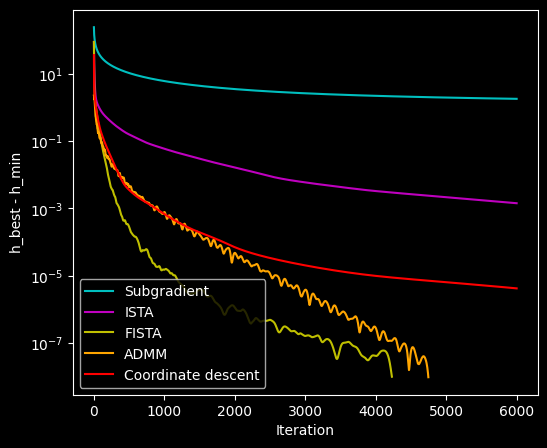

In [ ]:
x1 = np.zeros(n)
Rtrue = np.linalg.norm(x1 - x_var.value)
print(f"Optimal value (CVXPY) {h_min:.4f}")
tol = 1e-8
n_iter = 6000

fig, ax = plt.subplots(figsize=(6, 5))

start_time = time.time()
x_subgrad, hist_subgrad = subgrad_l1_ls(A, b, x1, lamb=lamb, a=1e-4, tol=tol, n_iter=n_iter)
print(f"\nOptimal h (Subgradient): {hist_subgrad['h_best'][-1]:.4f}")
print(f"time: {time.time() - start_time:.4f}s")

start_time = time.time()
x_ista, hist_ista = ista_l1_ls(A, b, x1, lamb=lamb, tol=tol, n_iter=n_iter, min=h_min)
print(f"\nOptimal h (ISTA): {hist_ista['h'][-1]:.4f}")
print(f"time: {time.time() - start_time:.4f}s")

start_time = time.time()
x_fista, hist_fista = fista_l1_ls(A, b, x1, lamb=lamb, tol=tol, n_iter=n_iter, min=h_min)
print(f"\nOptimal h (FISTA): {hist_fista['h'][-1]:.4f}")
print(f"time: {time.time() - start_time:.4f}s")

start_time = time.time()
x_admm, hist_admm = admm_l1_ls(A, b, x1, lamb=lamb, tol=tol, n_iter=n_iter, min=h_min)
print(f"\nOptimal h (ADMM): {hist_admm['h'][-1]:.4f}")
print(f"time: {time.time() - start_time:.4f}s")

start_time = time.time()
x_cd, hist_cd = cd_l1_ls(A, b, x1, lamb=lamb, tol=tol, n_iter=n_iter, min=h_min)
print(f"\nOptimal h (Coordinate descent): {hist_cd['h'][-1]:.4f}")
print(f"time: {time.time() - start_time:.4f}s")

ax.semilogy(np.arange(1, len(hist_subgrad['h_best'])), np.array(hist_subgrad['h_best'][1:]) - h_min, 'c-', label="Subgradient")
ax.semilogy(np.arange(1, len(hist_ista['h'])), np.array(hist_ista['h'][1:]) - h_min, 'm-', label="ISTA")
ax.semilogy(np.arange(1, len(hist_fista['h'])), np.array(hist_fista['h'][1:]) - h_min, 'y-', label="FISTA")
ax.semilogy(np.arange(1, len(hist_admm['h'])), np.array(hist_admm['h'][1:]) - h_min, '-', label="ADMM", c='orange')
ax.semilogy(np.arange(1, len(hist_cd['h'])), np.array(hist_cd['h'][1:]) - h_min, 'r-', label="Coordinate descent")
ax.set_xlabel('Iteration')
ax.set_ylabel('h_best - h_min')
ax.legend()

plt.show()